In [14]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import EstimatorV2 as Estimator

import matplotlib.pyplot as plt
import matplotlib.ticker as tck

In [15]:
# To run on hardware, select the backend with the fewest number of jobs in the queue
service=QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=127)
backend.name


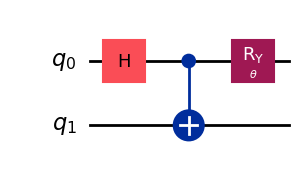

In [17]:
# Create an angle parameter
theta = Parameter("$\\theta$")
# Create a quantum circuit with 2 qubits
qc=QuantumCircuit(2)

# Create an entangled pair of qubits
qc.h(0)
qc.cx(0,1)
# Rotation gate on the 1st qubit
qc.ry(theta, 0)
qc.draw(output="mpl")

In [18]:
number_of_phases = 21 # number of angles for which we will test
phases = np.linspace(0, 2 * np.pi, number_of_phases)
# Phases need to be expressed as list of lists in order to work
individual_phases = [[ph] for ph in phases]

In [19]:
# Mapping the CHSH Formula to the Pauli Operators (Pauli operators will represent the observables <__>)

# <CHSH1> = <AB> - <Ab> + <aB> + <ab> -> <ZZ> - <ZX> + <XZ> + <XX>
observable1 = SparsePauliOp.from_list([("ZZ", 1), ("ZX", -1), ("XZ", 1), ("XX", 1)])

# <CHSH2> = <AB> + <Ab> - <aB> + <ab> -> <ZZ> + <ZX> - <XZ> + <XX>
observable2 = SparsePauliOp.from_list([("ZZ", 1), ("ZX", 1), ("XZ", -1), ("XX", 1)])

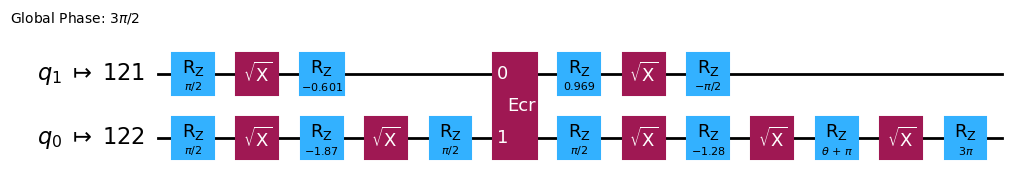

In [20]:
# needed for a simulator and not hardware -> from qiskit_aer import AerSimulator as Aer
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# needed for a simulator and not hardware -> backend = Aer(method='statevector')  # the statevector simulator
target = backend.target

pm = generate_preset_pass_manager(target=target, optimization_level=3)
qc_isa_circuit = pm.run(qc)

qc_isa_circuit.draw(output="mpl", idle_wires=False, style="iqp")



In [21]:
# Transform the observables to make it backend compatible before running jobs with Estimator
isa_observable1 = observable1.apply_layout(layout=qc_isa_circuit.layout)
isa_observable2 = observable2.apply_layout(layout=qc_isa_circuit.layout)

# Define individual observables for each part of the CHSH equation 
observable_AB=(isa_observable1[0])
observable_minus_Ab=(isa_observable1[1])
observable_aB=(isa_observable1[2])
observable_ab=(isa_observable1[3])
# Since minus is already integrated to Pauli operators e.g. ("ZX", 1), ("ZX", -1), 
# you need to differentiate between -Ab/Ab and -aB/aB observables
observable_Ab=(isa_observable2[1])
observable_minus_aB=(isa_observable2[2])


In [ ]:
# needed for a simulator -> from qiskit.primitives import StatevectorEstimator

# Initialize the estimator with the simulator backend
# estimator = StatevectorEstimator()

estimator = Estimator(mode=backend)

# Run the simulation and get the result
job_result = estimator.run([(qc_isa_circuit, [[observable_AB], [observable_minus_Ab], [observable_aB], [observable_ab], [observable_Ab], [observable_minus_aB]], phases)]).result()


In [95]:
# Access the individual expectation values:
AB = job_result[0].data.evs[0]
minus_Ab = job_result[0].data.evs[1] 
aB = job_result[0].data.evs[2]
ab = job_result[0].data.evs[3]
Ab=job_result[0].data.evs[4]
minus_aB=job_result[0].data.evs[4]

# Get S values 
CHSH_1= AB+minus_Ab+aB+ab
CHSH_2= AB+Ab+minus_aB+ab


In [96]:
# Make a table for expectation values

import pandas as pd
import numpy as np

expected_1 = np.round(AB, 3)
expected_2 = np.round(Ab, 3)
expected_3 = np.round(aB, 3)
expected_4 = np.round(ab, 3)

# Combine expected values into a 2D array
data = np.array([expected_1, expected_2, expected_3, expected_4])

# Create the DataFrame with expected values as columns and phases as rows
df = pd.DataFrame(data.T, index=[f"Phase {round(angle, 2)}" for angle in phases], columns=['<AB>', '<Ab>', '<aB>', '<ab>'])

# Set Pandas to display 3 decimal places
pd.options.display.float_format = '{:.3f}'.format

# Display the DataFrame
print(df)

             <AB>   <Ab>   <aB>   <ab>
Phase 0.0   1.000  0.000  0.000  1.000
Phase 0.31  0.951  0.309 -0.309  0.951
Phase 0.63  0.809  0.588 -0.588  0.809
Phase 0.94  0.588  0.809 -0.809  0.588
Phase 1.26  0.309  0.951 -0.951  0.309
Phase 1.57  0.000  1.000 -1.000  0.000
Phase 1.88 -0.309  0.951 -0.951 -0.309
Phase 2.2  -0.588  0.809 -0.809 -0.588
Phase 2.51 -0.809  0.588 -0.588 -0.809
Phase 2.83 -0.951  0.309 -0.309 -0.951
Phase 3.14 -1.000  0.000 -0.000 -1.000
Phase 3.46 -0.951 -0.309  0.309 -0.951
Phase 3.77 -0.809 -0.588  0.588 -0.809
Phase 4.08 -0.588 -0.809  0.809 -0.588
Phase 4.4  -0.309 -0.951  0.951 -0.309
Phase 4.71 -0.000 -1.000  1.000 -0.000
Phase 5.03  0.309 -0.951  0.951  0.309
Phase 5.34  0.588 -0.809  0.809  0.588
Phase 5.65  0.809 -0.588  0.588  0.809
Phase 5.97  0.951 -0.309  0.309  0.951
Phase 6.28  1.000 -0.000  0.000  1.000


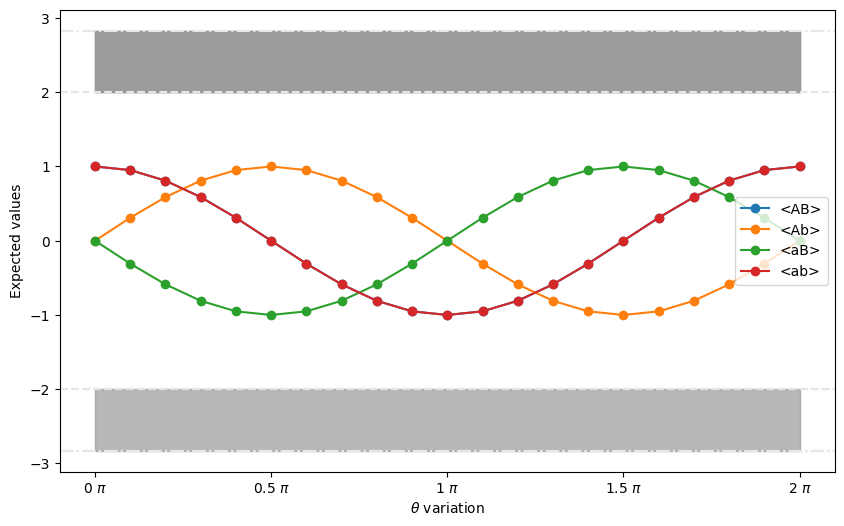

In [97]:
# Graph Expectated values vs angle variation

fig, ax = plt.subplots(figsize=(10, 6))

# results from hardware
ax.plot(phases / np.pi, AB, "o-", label="<AB>", zorder=3)
ax.plot(phases / np.pi, Ab, "o-", label="<Ab>", zorder=3)
ax.plot(phases / np.pi, aB, "o-", label="<aB>", zorder=3)
ax.plot(phases / np.pi, ab, "o-", label="<ab>", zorder=3)

# classical bound +-2
ax.axhline(y=2, color="0.9", linestyle="--")
ax.axhline(y=-2, color="0.9", linestyle="--")
ax.axhline(y=-2, color="0.9", linestyle="--")
ax.axhline(y=-2, color="0.9", linestyle="--")

# quantum bound, +-2√2
ax.axhline(y=np.sqrt(2) * 2, color="0.9", linestyle="-.")
ax.axhline(y=-np.sqrt(2) * 2, color="0.9", linestyle="-.")
ax.axhline(y=-np.sqrt(2) * 2, color="0.9", linestyle="-.")
ax.axhline(y=-np.sqrt(2) * 2, color="0.9", linestyle="-.")

ax.fill_between(phases / np.pi, 2, 2 * np.sqrt(2), color="0.6", alpha=0.7)
ax.fill_between(phases / np.pi, -2, -2 * np.sqrt(2), color="0.6", alpha=0.7)
ax.fill_between(phases / np.pi, 2, 2 * np.sqrt(2), color="0.6", alpha=0.7)
ax.fill_between(phases / np.pi, 2, 2 * np.sqrt(2), color="0.6", alpha=0.7)

# Details
ax.xaxis.set_major_formatter(tck.FormatStrFormatter("%g $\\pi$"))
ax.xaxis.set_major_locator(tck.MultipleLocator(base=0.5))

plt.xlabel("$\\theta$ variation")
plt.ylabel("Expected values")
plt.legend()
plt.show()

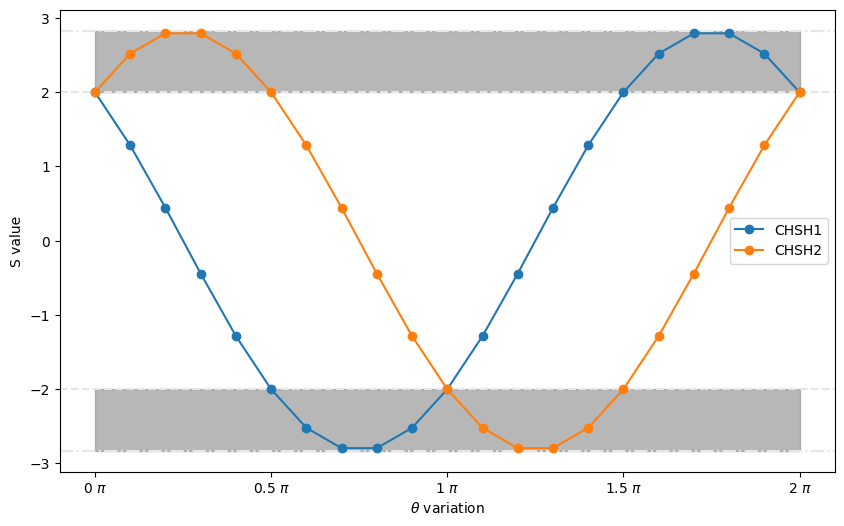

In [98]:
# Graph S vs. angle variation

fig, ax = plt.subplots(figsize=(10, 6))

# results from hardware
ax.plot(phases / np.pi, CHSH_1, "o-", label="CHSH1", zorder=3)
ax.plot(phases / np.pi, CHSH_2, "o-", label="CHSH2", zorder=3)

# classical bound +-2
ax.axhline(y=2, color="0.9", linestyle="--")
ax.axhline(y=-2, color="0.9", linestyle="--")

# quantum bound, +-2√2
ax.axhline(y=np.sqrt(2) * 2, color="0.9", linestyle="-.")
ax.axhline(y=-np.sqrt(2) * 2, color="0.9", linestyle="-.")
ax.fill_between(phases / np.pi, 2, 2 * np.sqrt(2), color="0.6", alpha=0.7)
ax.fill_between(phases / np.pi, -2, -2 * np.sqrt(2), color="0.6", alpha=0.7)

# Details 
ax.xaxis.set_major_formatter(tck.FormatStrFormatter("%g $\\pi$"))
ax.xaxis.set_major_locator(tck.MultipleLocator(base=0.5))


plt.xlabel("$\\theta$ variation")
plt.ylabel("S value")
plt.legend()
plt.show()